In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

In [2]:
# Helper function to create an agent

def create_agent(llm,tools,system_message):
    """
    Will create agents

    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # constructing the prompt
    prompt = prompt.partial(system_message = system_message)

    tool_names = ", ".join([tool.name for tool in tools])

    prompt = prompt.partial(tool_names = tool_names)

    return prompt | llm.bind_tools(tools)
        


In [1]:
# Defining the tools

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Web search tool for Researcher agent
tavily_tool = TavilySearchResults(max_results = 5)

# Executing code locally

# Defining the python execution
repl = PythonREPL()

@ tool
def python_repl(code:Annotated[str,"Python code to generate your chart."]):
    """
    Use this to exceute the python code. If you want to see output of a value,
    you should print it out with print(...). This is visible to the user.

    """
    try:

        result = repl.run(code)
    
    except BaseException as e:
        return f"Error faced. Error: {e}"
    
    result_str = f"Successful execution: \n ```python\n{code}\n```Stdout: {result}"

    return (result_str + "\n\n If you have completed all tasks, respond with FINAL ANSWER")


Creating the Graph


In [5]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict


from langchain_openai import ChatOpenAI


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [6]:
import functools
from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent

def agent_node(state,agent,name):
    # Invokes the agent
    result = agent.invoke(state)

    if isinstance(result,ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude = {'type','name'}))
        result.name = name
    
    #  Returning the updated stae
    return {
        'messages': [result],
        'sender': name
    }
# Defining the LLM
llm = ChatOpenAI(model = 'gpt-4o')

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message = "You should provide accurate data for the chart generator to use"
)

# Assigning the research agent as a node
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


# Chart generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message = "Any charts you display will be visible to the user"
)

chart_node = functools.partial(agent_node,agent = chart_agent,name = 'chart_generator')



In [7]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [8]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]

    # If last message is a tool call
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    
    return "continue"



In [9]:
# Graph workflow

workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)

workflow.add_edge(START, "Researcher")
graph = workflow.compile()



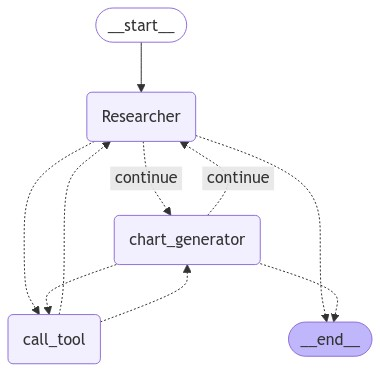

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Z808TgTi0b1O88fly6GiafV7', 'function': {'arguments': '{"query":"India population trend last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 218, 'total_tokens': 242, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7e2833e5f9', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-ca054230-ba8f-440a-b053-cb075a6b1ca2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'India population trend last 5 years'}, 'id': 'call_Z808TgTi0b1O88fly6GiafV7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_to

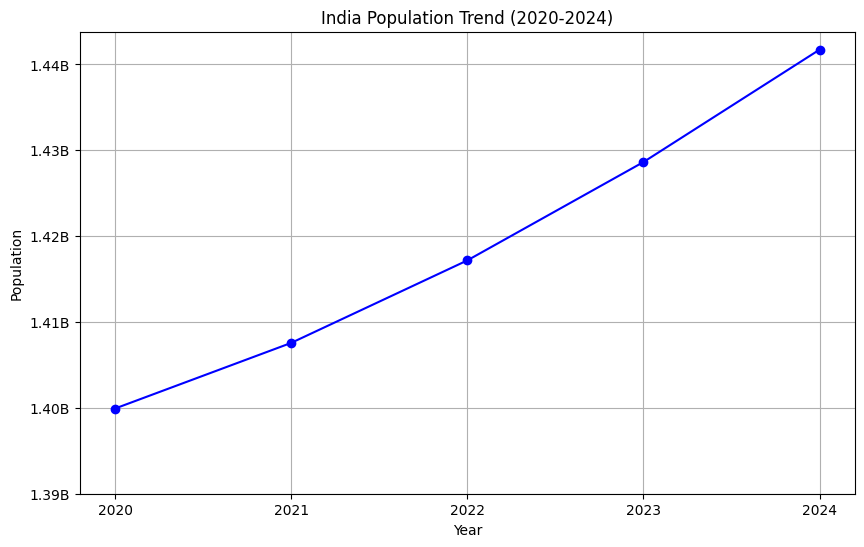

{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EPAsFeKlRIA2inMfag9jDSaw', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for India\'s population over the past 5 years\\nyears = [2020, 2021, 2022, 2023, 2024]\\npopulation = [1399921000, 1407563842, 1417173173, 1428627663, 1441719852]\\n\\n# Plotting the line graph\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, population, marker=\'o\', color=\'b\', linestyle=\'-\')\\nplt.title(\'India Population Trend (2020-2024)\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'Population\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.yticks(range(1390000000, 1450000000, 10000000), [f\'{i/1e9:.2f}B\' for i in range(1390000000, 1450000000, 10000000)])\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 234, 'prompt_tokens': 1302, 'total_tokens': 1536, 'prompt_tokens_details': {'cached_tokens

In [13]:
from pprint import pprint
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the India's population trend over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 50},
)
for s in events:
    pprint(s)
    print("----")